# Import

In [8]:
%pylab inline
import math
import pandas as pd
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels import api as sm

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score

from data import get_data

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test', 'ma']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Data

아래의 링크에서 데이터를 다운받을 수 있습니다.<br>
[Daily minimum temperatures in Melbourne, Australia, 1981-1990](https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line)

[Header]
Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, dtype: float64

Train Size: (3600, 1)
Test Size : (50, 1)


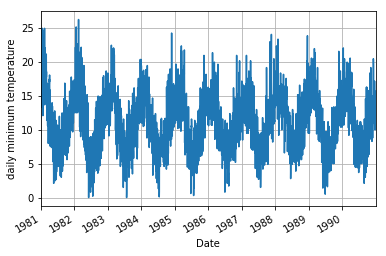

In [10]:
TEST_SIZE = 50

_filename= '/dataset/daily-minimum-temperature-in-melbourne/daily-minimum-temperatures-in-me.csv'
dataframe = pd.Series.from_csv(_filename, header=0)
dataframe.index = dataframe.index.to_datetime()
dataframe = dataframe.astype('float64')
print('[Header]')
print(dataframe.head())
dataframe.plot(grid=True)
ylabel('daily minimum temperature')

# Normalization 
scaler = MinMaxScaler()
data = scaler.fit_transform(dataframe.values.reshape((-1, 1)))

# Split Training and Test Data
train, test = data[:-TEST_SIZE], data[-TEST_SIZE:]
# train, test = train_test_split(data, test_size=0.1)
# train_data, test_data = data[0:len(data)-7], data[len(data)-7:]
print()
print('Train Size:', train.shape)
print('Test Size :', test.shape)

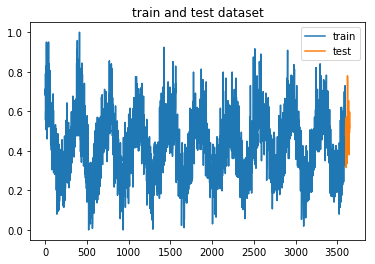

In [3]:
plot(np.arange(len(train)), train, label='train')
plot(np.arange(len(train), len(train)+len(test)), test, label='test')
legend()
title('train and test dataset')

            passenger
1949-01-01      112.0
1949-02-01      118.0
1949-03-01      132.0
1949-04-01      129.0
1949-05-01      121.0


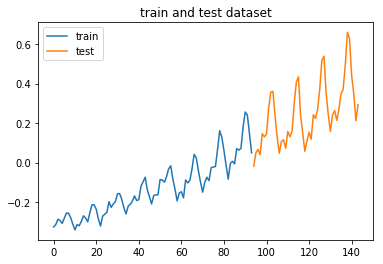

In [11]:
LAG = 12
filename = '/dataset/time-series/international-airline-passengers.csv'
dataframe, train, test, ts_train, ts_test = get_data(filename, LAG)

print(dataframe.head())
plot(np.arange(len(train)), train, label='train')
plot(np.arange(len(train), len(train)+len(test)), test, label='test')
legend()
title('train and test dataset')

# Moving Average Model

* [PennState STAT 510 - Moving Average Models(MA Models)](https://onlinecourses.science.psu.edu/stat510/node/48)

* [Numpy Cookbook 참고](https://books.google.co.kr/books?id=zWHCCAAAQBAJ&pg=PA222&lpg=PA222&dq=numpy+%22moving+average+model%22&source=bl&ots=VWJa0wmEaP&sig=l_pgyToRagDVGnHA_UUo5DO0Ofg&hl=en&sa=X&ved=0ahUKEwig--Ppw4_VAhWIUrwKHWShDQoQ6AEIOTAE#v=onepage&q=numpy%20%22moving%20average%20model%22&f=false)

Moving-average Model MA(q)는 AR(p)와 매우 유사하며 마찬가지로 univariate time series를 모델링 하는데 사용되는 방법중의 하나입니다. <br>
두 모델의 차이점은 MA(q) 모델의 경우 과거의 white noise error를 사용합니다. <br>
<span style="color:red">즉 AR(p)의 경우 과거 p값 만큼의 과거의 lagged variables사용해서 예측을 하는 반면, <br>
MA(q) 모델은 과거의 예측 에러(forecast errors)에서 나온 값을 사용해서 예측을 합니다.</span>

AR Model과 함께 ARMA 그리고 ARIMA 모델의 중요 컴포넌트가 됩니다.<br> 

> Moving Average Model은 Moving Average와 전혀 다릅니다.

### Definition

MA(q) 모델은 noise에 관하여 $ X_t $에 대해 다음과 같이 정의를 하고 있습니다.

$$ X_t = c + \epsilon_t + \beta_1 \epsilon_{t-1} + ... + \beta_q \epsilon_{t-q} $$

$ \epsilon $ 기호는 error (white noise)로 읽으면 됩니다. (epsilon이 아니라..) <br>
noise 의 (weighted)평균으로 구해지지만 전체 시간을 모두 구하는 것이 아니라, average moving $ t $ 그리고 $ q+1 $ times가 사용됩니다.<br>
time lags를 사용하여 다음과 같이 정의 할 수 있습니다.

$$ X_t = c+ \left(1 + \sum^q_{k=1} \beta_k L^k \right) \epsilon_t $$

## Code


In [6]:
from scipy.optimize import leastsq
from statsmodels.regression.linear_model import GLS

class MA(object):
    def __init__(self, lag=5):
        self.lag = lag
        self.w = np.random.rand(lag)
        print(self.w)
        
    def fit(self, x):
        mean = x.mean()
        a, b = leastsq(self.error, self.w, args=(x-mean,) )
        
        gls = GLS(x[1:], x[:-1]).fit()
        print(gls.params)
        return gls
        
        
    def error(self, w, x):
        return w * x[:self.lag].reshape(-1)
        
ma = MA()
gls = ma.fit(train)



[ 0.11741529  0.86292294  0.39186624  0.74916259  0.84858874]
[ 0.9579881]


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   94
Model:                     ARMA(4, 2)   Log Likelihood                 172.898
Method:                       css-mle   S.D. of innovations              0.037
Date:                Tue, 08 Aug 2017   AIC                           -329.796
Time:                        18:31:19   BIC                           -309.449
Sample:                             0   HQIC                          -321.577
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1286      0.083     -1.545      0.126      -0.292       0.034
ar.L1.y        1.9170      0.120     15.967      0.000       1.682       2.152
ar.L2.y       -1.9104      0.229     -8.327      0.0

NameError: name 'model_ar' is not defined

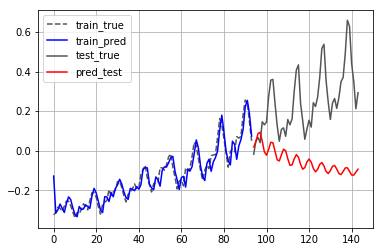

In [7]:
model_arma = ARMA(train, order=(4, 2, 1))
model_arma = model_arma.fit(max_lag=30)
print(model_arma.summary())

pred_train = model_arma.predict(0)
pred_test = model_arma.predict(start=len(train), end=len(train) + len(test)-1)

x_train = np.arange(len(pred_train))
x_test = np.arange(len(pred_train), len(pred_train) + len(pred_test))

plot(x_train, train, linestyle="--", label='train_true', color="#555555")
plot(x_train, pred_train, label='train_pred', color='blue')
plot(x_test, test, label='test_true',  color='#555555')
plot(x_test, pred_test, label='pred_test', color='red')
legend()
grid()

print('Lag:', model_ar.k_ar)
print('Params:', model_ar.params.shape)
print('Train R^2:', r2_score(pred_train, train))
print('Train MSE:', mean_squared_error(pred_train, train))
print('Test  R^2:', r2_score(pred_test, test))
print('Test  MSE:', mean_squared_error(pred_test, test))

# ARMA (AutoRegressive Moving Average) Model

ARMA(p, q) (AutoRegressive Moving Average with orders p and q) 는 AR(p) 와 MA(q) 를 합친 모델이며, univariate time series 모델링에 적합합니다.<br>
미래의 값은.. 과거 p 관측치 그리고 random error를 합친 것으로 여깁니다.

* AR(p) 모델은 momentum 그리고 주식시장에서 주로 나타나는.. mean reversion effect 를 설명합니다.
* MA(q) 모델은 white noise에서 관측되는 shock effects 를 설명합니다. <br>shock effects는 예상치못한 이벤트로 설명될수 있습니다. 예를 들어서 서프라이즈 어닝 또는 테러공격등등..


$$ \left( 1 - \sum^p_{k=1} \alpha_k L^k \right) X_t = \left( 1 + \sum^q_{k=1} \beta_k L^k \right) \epsilon_t $$

풀어쓰면 다음과 같습니다.

$$ X_t = \alpha_1 X_{t-1} + ... + \alpha_p X_{t-p} + \epsilon_t + \beta_1 \epsilon_{t-1} + ... + \beta_q \epsilon_{t-q} $$

### ARMA 코드 구현

Python from statsmodels.tsa.arima_model 안의 ARMA 를 사용해서 구현할수 있습니다. <br>
사용되는 공식은 다음과 같습니다.

![alt text](images/arma.jpg " jaja")



In [ ]:
arma = ARMA(train, (29, 5))
arma.endog

# Auto-Regressive Integrated Moving Average (ARIMA)

ARIMA를 적용하기 위해서는 time series는 linear 하며 통계적 분포(normal distribution같은 statistical distribution)을 따른다고 가정합니다. <br>
다음의 모델들의 특징을 모두 갖고 있습니다.

* Autoregressive (AR)
* Moving Average (MA)

# References 

* https://gejza.nipax.cz/_media/stochasticke_procesy:1302.6613.pdf
* http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016#MA
* http://www.uh.edu/~bsorense/arma-intro2012.pdf
* http://users.dma.unipi.it/~flandoli/AUTCap4.pdf
* https://en.wikipedia.org/wiki/Lag_operator
* http://homepage.stat.uiowa.edu/~rdecook/stat2020/notes/ch5_pt1.pdf
* http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016